To test that linear response theory is recovering the true amplification of freshwater fluxes, we need to evaluate the amplification of fluxes from CESM flux fields. Note that as linear response theory is finding the change in freshwater fluxes as a proportion of the FAFMIP perturbation, the truth is not exactly the change in magnitude of freshwater fluxes, but rather the change of the projection of the freshwater fluxes onto the FAFMIP pattern. There are other ways that we have thought of to quantify the true fluxes which are shown in the "true_freshwater_fluxes_options.ipynb" notebook.

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe

In [4]:
#First, load in all the freshwater fluxes. See notebook processing_salt_fluxes.py for how to generate this files that we unpickle here

import pickle
with open("/scratch/abf376/regridded_salt_flux_historical", "rb") as fp:   #Unpickling, replace string with drectory where pickled file lives
    regridded=pickle.load(fp)

with open("/scratch/abf376/regridded_salt_flux_2005on", "rb") as fp:   #Unpickling
    regridded_2005on=pickle.load(fp)

First we calculate the true fluxes for the ensemble mean

In [5]:
#average over ensemble member
salt_flux_avg_pre2005=sum(regridded)/34
salt_flux_avg_pre2005=salt_flux_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_pre2005=salt_flux_avg_pre2005.assign_coords(latitude=salt_flux_avg_pre2005.lat[:,0],longitude=salt_flux_avg_pre2005.lon[0,:])

salt_flux_avg_2005on=sum(regridded_2005on)/34
salt_flux_avg_2005on=salt_flux_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_2005on=salt_flux_avg_2005on.assign_coords(latitude=salt_flux_avg_2005on.lat[:,0],longitude=salt_flux_avg_2005on.lon[0,:])

In [6]:
salt_avg=xr.concat([salt_flux_avg_pre2005,salt_flux_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
salt_flux_avg_1970to2019=salt_avg[12*50:12*100,:,:] #salt_avg was from 1920 to 2080 so this is from 1970 to 2019
a=np.linspace(1920,2080,161)
print(a[50:100])

climatological_salt_flux=salt_avg[0:12*55,:,:].mean('time') #this is 1920 to 1975

[1970. 1971. 1972. 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981.
 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993.
 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005.
 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017.
 2018. 2019.]


In [7]:
#create area grid

import sys
sys.path.insert(1, '/scratch/abf376/')
from area_grid import *

area=area_grid(latitudes=np.array(salt_flux_avg_pre2005[0,:,:].latitude),longitudes=salt_flux_avg_pre2005[0,:,:].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_flux_avg_pre2005[0,:,:].latitude,salt_flux_avg_pre2005[0,:,:].longitude])

In [20]:
#water flux from fafmip
f='/scratch/abf376/FAFMIP_wfo_v2.nc' #this is the first 50 years
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
wfo = xr.open_dataset(f)['water_flux_into_sea_water']
wfo=wfo.where(wfo<1E19)


area_wfo=area_grid(latitudes=np.array(wfo.latitude),longitudes=wfo.longitude)
area_wfo=xr.DataArray(area,dims=["latitude","longitude"],coords=[wfo.latitude,wfo.longitude])

In [21]:
#regrid wfo
ds_out = xe.util.grid_global(1, 1)
regridder_wfo= xe.Regridder(wfo, ds_out, "bilinear",periodic=True)
wfo = regridder_wfo(wfo)
wfo=wfo.rename({'y': 'latitude','x': 'longitude'})
wfo=wfo.assign_coords(latitude=wfo.lat[:,0],longitude=wfo.lon[0,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [166]:
#now we want to compute the projection of cesm fluxes onto the fafmip perturbation field

y=np.reshape(wfo.mean('time')*area.where(area.latitude<65),(1,180*360)) #reshape the perturbation field to be a vector

proj=np.empty(50)
err=np.empty(50)
for i in range(0,50):
    x=np.reshape(salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')*area.where(area.latitude<65),(1,180*360))
    proj[i]=np.nansum(x*y)/(np.nansum(y*y))
    err[i]=(np.nansum(np.abs(proj[i]*y)))/(np.nansum(np.abs(x-proj[i]*y))) #portion of cesm salt flux explained by projection divided by proportion of salt flux explained by rejection. come back to this

Text(0, 0.5, 'Normalized scalar projection')

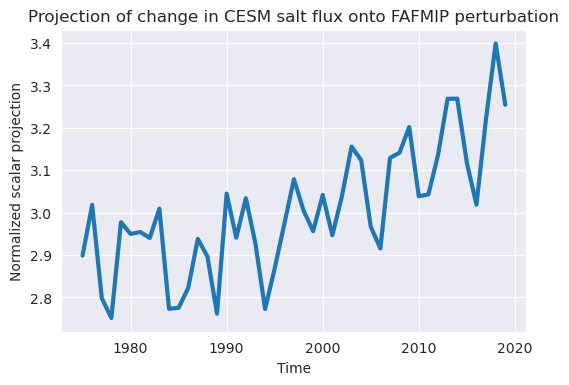

In [369]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.plot(np.linspace(1975,2019,45),proj[5:50],linewidth=3)
plt.xlabel('Time')
plt.title('Projection of change in CESM salt flux onto FAFMIP perturbation')
plt.ylabel('Normalized scalar projection')

In [279]:
# do block bootstrapping to deal with effect of natural variability 

np.random.seed(0)

change=np.empty([500])
trend=np.empty([45])
p=scipy.stats.linregress(np.linspace(0,44,45), y=proj[5:50], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 500

y_star_cb \
    = circular_block_bootstrap(proj[5:50]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    change[i]=(bootstrap[i][40:45].mean()-bootstrap[i][0:5].mean())
print(change.mean())
print(change.std())

0.3347435703309112
0.0696193098065107


Can instead project the change in the salt fluxes from the beginning of the timeseries. This ultimately is the same thing because $a \cdot (b+c)=a\cdot b + a\cdot c$. Thus, subtracting off the climatological pattern doesn't affect the outcome

In [352]:
#Can compute a slightly different thing which is the projection of the change of the salt flux from the climatological

y=np.array(np.reshape(wfo.mean('time')*area.where(area.latitude<65),(1,180*360))) #reshape the perturbation field to be a vector

proj2=np.empty(50)
err2=np.empty(50)
for i in range(0,50):
    x=np.array(np.reshape((salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')-salt_flux_avg_1970to2019[0*12:(5)*12,:,:].mean('time'))*area.where(area.latitude<65),(1,180*360)))
    proj2[i]=np.nansum(x*y)/(np.nansum(y*y))
    err2[i]=np.sqrt(np.nansum((proj2[i]*y)**2))/np.sqrt(np.nansum((x)**2)) #portion of cesm salt flux explained by projection divided by total

Text(0, 0.5, 'Normalized scalar projection')

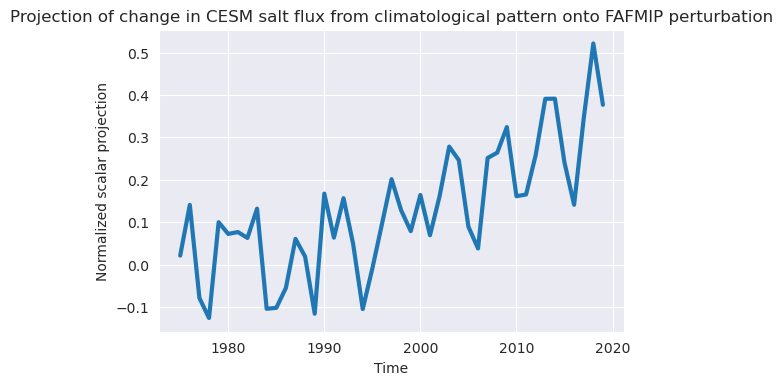

In [368]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.plot(np.linspace(1975,2019,45),proj2[5:50],linewidth=3)
plt.xlabel('Time')
plt.title('Projection of change in CESM salt flux from climatological pattern onto FAFMIP perturbation')
plt.ylabel('Normalized scalar projection')

In [351]:
z=np.array(np.reshape((salt_flux_avg_1970to2019[45*12:(50)*12,:,:].mean('time')-salt_flux_avg_1970to2019[0*12:(5)*12,:,:].mean('time'))*area.where(area.latitude<65),(1,180*360)))
np.sqrt(np.nansum((proj2[i]*y)**2))/np.sqrt(np.nansum((z)**2)) #near the end of the timeseries, the projection is about half the length of the total

0.4948810038151973

In [287]:
# do block bootstrapping to deal with effect of natural variability 

np.random.seed(0)

change=np.empty([500])
trend=np.empty([45])
p=scipy.stats.linregress(np.linspace(0,44,45), y=proj2[5:50], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 500

y_star_cb \
    = circular_block_bootstrap(proj2[5:50]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    change[i]=(bootstrap[i][40:45].mean()-bootstrap[i][0:5].mean())
print(change.mean())
print(change.std())

0.334743570340687
0.06961930978721081


Now, we need to do the same for each individual member

In [206]:
# a list of all ensemble members
for i in range(0,34):
    regridded[i]=regridded[i].rename({'y': 'latitude','x': 'longitude'})
    regridded[i]=regridded[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
    regridded_2005on[i]=regridded_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    regridded_2005on[i]=regridded_2005on[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
salt_avg_list=[]
for i in range(0,34):
    salt_avg_list.append(xr.concat([regridded[i],regridded_2005on[i]],dim="time"))
    
climatological_salt_flux_list=[]
for i in range(0,34):
    climatological_salt_flux_list.append(salt_avg_list[i][0:12*55,:,:].mean('time')) #this is 1920 to 1975
    salt_avg_list[i]=salt_avg_list[i][12*50:12*100,:,:]

In [207]:
proj_list=np.empty([34,50])
for j in range(0,34):
    for i in range(0,50):
        x=np.reshape(salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')*area.where(area.latitude<65),(1,180*360))
        proj_list[j,i]=np.nansum(x*y)/(np.nansum(y*y))

In [274]:
pval_store=np.empty(34)
np.random.seed(0)
change=np.empty([3000,34])
for j in range(0,34):
    trend=np.empty([45])
    p=scipy.stats.linregress(np.linspace(0,44,45), y=proj_list[j,5:50], alternative='two-sided')
    trend=p.intercept+p.slope*np.linspace(0,44,45)
    pval_store[j]=p.pvalue

    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 3000

    y_star_cb \
        = circular_block_bootstrap(proj_list[j,5:50]-trend, 
                                   block_length=2, 
                                   replications=B, replace=True)
    bootstrap=[]
    for i in range(0,B):
        bootstrap.append(trend+y_star_cb[i,:])

    for i in range(0,B):
        change[i,j]=(bootstrap[i][40:45].mean()-bootstrap[i][0:5].mean())

mean_boot=np.empty([34])
std_boot=np.empty([34])
con_interval_low=np.empty([34])
con_interval_high=np.empty([34])
for j in range(0,34):
    mean_boot[j]=change[:,j].mean()
    std_boot[j]=change[:,j].std()

As above, we can instead project the change in the salt flux pattern. Ultimately, though, this gives the same value as noted above

In [246]:
proj2_list=np.empty([34,50])
for j in range(0,34):
    for i in range(0,50):
        x=np.reshape((salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')-salt_avg_list[j][0*12:(5)*12,:,:].mean('time'))*area.where(area.latitude<65),(1,180*360))
        proj2_list[j,i]=np.nansum(x*y)/(np.nansum(y*y))

In [247]:
pval_store=np.empty(34)
np.random.seed(0)
change=np.empty([3000,34])
for j in range(0,34):
    trend=np.empty([45])
    p=scipy.stats.linregress(np.linspace(0,44,45), y=proj2_list[j,5:50], alternative='two-sided')
    trend=p.intercept+p.slope*np.linspace(0,44,45)
    pval_store[j]=p.pvalue

    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 3000

    y_star_cb \
        = circular_block_bootstrap(proj2_list[j,5:50]-trend, 
                                   block_length=2, 
                                   replications=B, replace=True)
    bootstrap=[]
    for i in range(0,B):
        bootstrap.append(trend+y_star_cb[i,:])

    for i in range(0,B):
        change[i,j]=(bootstrap[i][40:45].mean())

mean_boot2=np.empty([34])
std_boot2=np.empty([34])
con_interval_low=np.empty([34])
con_interval_high=np.empty([34])
for j in range(0,34):
    mean_boot2[j]=change[:,j].mean()
    std_boot2[j]=change[:,j].std()